# WaterTAP Introduction Tutorial
Demonstration of code-based user interface for WaterTAP

## Dependencies
* Python - Programming language
* Pyomo - Python package for equation-oriented modeling
* IDAES - Python package extending Pyomo for flowsheet modeling

## Demonstration structure 
* Pyomo example
* Property model example
* Unit model example
* Flowsheet model example
* Cost optimization example

## Pyomo Example
We want to minimize $x^{2}_{1} + x^{2}_{2}$ subject to $x_{1} + 2x_{2}$ $\geq$ 1

$${\Large
\begin{array}
 \text{\min} & x_1^2 + x_2^2  \\
 \text{s.t.} & x_1 + 2 x_2 \geq 1 
\end{array}}$$

### Solving Graphically
x1 = 0.2, x2 = 0.4, objective = 0.2

<img src="pyomo_solution.png" width="500" height="340">

### Solving with Pyomo
### Import Pyomo package and solver

In [1]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, value, units
from watertap.core.solvers import get_solver

### Build model

In [2]:
# create Pyomo model
m = ConcreteModel()

# add variables
m.x1 = Var()
m.x2 = Var()

# add objective function
m.obj = Objective(expr=m.x1**2 + m.x2**2)

# add constraint
m.con = Constraint(expr=m.x1 + 2*m.x2 >= 1)

### Print model

In [3]:
# print the model
m.pprint()

2 Var Declarations
    x1 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :  None :  None : False :  True :  Reals
    x2 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :  None :  None : False :  True :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : x1**2 + x2**2

1 Constraint Declarations
    con : Size=1, Index=None, Active=True
        Key  : Lower : Body      : Upper : Active
        None :   1.0 : x1 + 2*x2 :  +Inf :   True

4 Declarations: x1 x2 obj con


### Solve model

In [4]:
# access the solver
solver = get_solver()

# solve the model
results = solver.solve(m)

# display the model
m.display()

Model unknown

  Variables:
    x1 : Size=1, Index=None
        Key  : Lower : Value               : Upper : Fixed : Stale : Domain
        None :  None : 0.20000000125783673 :  None : False : False :  Reals
    x2 : Size=1, Index=None
        Key  : Lower : Value               : Upper : Fixed : Stale : Domain
        None :  None : 0.40000000251567347 :  None : False : False :  Reals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 0.20000000251567346

  Constraints:
    con : Size=1
        Key  : Lower : Body               : Upper
        None :   1.0 : 1.0000000062891836 :  None


### Print results

In [5]:
# print the values
print("x1 = %.2f" % value(m.x1))
print("x2 = %.2f" % value(m.x2))
print("obj = %.2f" % value(m.obj))

x1 = 0.20
x2 = 0.40
obj = 0.20


### Pyomo recap
* Pyomo supports equation oriented modeling and optimization capabilities within Python
* Models are created by simply specifiying variables, constraints, and objectives
* Models are solved with commercial or open-source solvers

## WaterTAP Seawater Property Example
This section shows how to create and solve a [seawater property model](https://watertap.readthedocs.io/en/latest/technical_reference/property_models/seawater.html) using WaterTAP.

### Import WaterTAP and IDAES

In [6]:
from idaes.core import FlowsheetBlock
from idaes.core.util.scaling import calculate_scaling_factors, set_scaling_factor
import watertap.property_models.seawater_prop_pack as properties

### Create a seawater state block

In [7]:
# create pyomo model
m = ConcreteModel()

# create IDAES flowsheet
m.fs = FlowsheetBlock(dynamic=False)

# create seawater property model
m.fs.properties = properties.SeawaterParameterBlock()

# create a state block using the property model
m.fs.state_block = m.fs.properties.build_state_block([0])

# display the default values in the state block
m.fs.state_block[0].display()

Block fs.state_block[0]

  Variables:
    flow_mass_phase_comp : Mass flow rate
        Size=2, Index=fs.properties.phase_list*fs.properties.component_list, Units=kg/s
        Key            : Lower : Value : Upper : Fixed : Stale : Domain
        ('Liq', 'H2O') :   0.0 : 0.965 :  None : False : False : NonNegativeReals
        ('Liq', 'TDS') :   0.0 : 0.035 :  None : False : False : NonNegativeReals
    temperature : Temperature
        Size=1, Index=None, Units=K
        Key  : Lower  : Value  : Upper : Fixed : Stale : Domain
        None : 273.15 : 298.15 :  1000 : False : False : NonNegativeReals
    pressure : Pressure
        Size=1, Index=None, Units=Pa
        Key  : Lower  : Value  : Upper      : Fixed : Stale : Domain
        None : 1000.0 : 101325 : 50000000.0 : False : False : NonNegativeReals

  Objectives:
    None

  Constraints:
    None


### Set the state variables

In [8]:
# fix state variables
m.fs.state_block[0].temperature.fix(273 + 25)                      # temperature (K)
m.fs.state_block[0].pressure.fix(101325)                           # pressure (Pa)
m.fs.state_block[0].flow_mass_phase_comp['Liq', 'H2O'].fix(0.965)  # mass flowrate of H2O (kg/s)
m.fs.state_block[0].flow_mass_phase_comp['Liq', 'TDS'].fix(0.035)  # mass flowrate of TDS (kg/s)

# display modified state block
m.fs.state_block[0].display()

Block fs.state_block[0]

  Variables:
    flow_mass_phase_comp : Mass flow rate
        Size=2, Index=fs.properties.phase_list*fs.properties.component_list, Units=kg/s
        Key            : Lower : Value : Upper : Fixed : Stale : Domain
        ('Liq', 'H2O') :   0.0 : 0.965 :  None :  True : False : NonNegativeReals
        ('Liq', 'TDS') :   0.0 : 0.035 :  None :  True : False : NonNegativeReals
    temperature : Temperature
        Size=1, Index=None, Units=K
        Key  : Lower  : Value : Upper : Fixed : Stale : Domain
        None : 273.15 :   298 :  1000 :  True : False : NonNegativeReals
    pressure : Pressure
        Size=1, Index=None, Units=Pa
        Key  : Lower  : Value  : Upper      : Fixed : Stale : Domain
        None : 1000.0 : 101325 : 50000000.0 :  True : False : NonNegativeReals

  Objectives:
    None

  Constraints:
    None


### Create mass fraction property

In [9]:
# attempting to access a property will automatically create the variable and constraint
m.fs.state_block[0].mass_frac_phase_comp

# display the state block
m.fs.state_block[0].display()

# note that the variable and its constraint are only created, it has not been solved yet

Block fs.state_block[0]

  Variables:
    flow_mass_phase_comp : Mass flow rate
        Size=2, Index=fs.properties.phase_list*fs.properties.component_list, Units=kg/s
        Key            : Lower : Value : Upper : Fixed : Stale : Domain
        ('Liq', 'H2O') :   0.0 : 0.965 :  None :  True : False : NonNegativeReals
        ('Liq', 'TDS') :   0.0 : 0.035 :  None :  True : False : NonNegativeReals
    temperature : Temperature
        Size=1, Index=None, Units=K
        Key  : Lower  : Value : Upper : Fixed : Stale : Domain
        None : 273.15 :   298 :  1000 :  True : False : NonNegativeReals
    pressure : Pressure
        Size=1, Index=None, Units=Pa
        Key  : Lower  : Value  : Upper      : Fixed : Stale : Domain
        None : 1000.0 : 101325 : 50000000.0 :  True : False : NonNegativeReals
    mass_frac_phase_comp : Mass fraction
        Size=2, Index=fs.properties.phase_list*fs.properties.component_list, Units=dimensionless
        Key            : Lower : Value : Upper 

### Solve state block to determine mass fraction

In [10]:
# solve the state block
solver.solve(m.fs.state_block[0])

# display the state block
m.fs.state_block[0].display()

Block fs.state_block[0]

  Variables:
    flow_mass_phase_comp : Mass flow rate
        Size=2, Index=fs.properties.phase_list*fs.properties.component_list, Units=kg/s
        Key            : Lower : Value : Upper : Fixed : Stale : Domain
        ('Liq', 'H2O') :   0.0 : 0.965 :  None :  True :  True : NonNegativeReals
        ('Liq', 'TDS') :   0.0 : 0.035 :  None :  True :  True : NonNegativeReals
    temperature : Temperature
        Size=1, Index=None, Units=K
        Key  : Lower  : Value : Upper : Fixed : Stale : Domain
        None : 273.15 :   298 :  1000 :  True :  True : NonNegativeReals
    pressure : Pressure
        Size=1, Index=None, Units=Pa
        Key  : Lower  : Value  : Upper      : Fixed : Stale : Domain
        None : 1000.0 : 101325 : 50000000.0 :  True :  True : NonNegativeReals
    mass_frac_phase_comp : Mass fraction
        Size=2, Index=fs.properties.phase_list*fs.properties.component_list, Units=dimensionless
        Key            : Lower : Value : Upper 

### Create and solve osmotic pressure property

In [11]:
# create osmotic pressure
m.fs.state_block[0].pressure_osm_phase

# solve the state block
solver.solve(m.fs.state_block[0])

# display the state block
m.fs.state_block[0].display()

# note that other intermediate variables were needed to calculate osmotic pressure
# and they were automatically created with the constraints to calculate them

Block fs.state_block[0]

  Variables:
    flow_mass_phase_comp : Mass flow rate
        Size=2, Index=fs.properties.phase_list*fs.properties.component_list, Units=kg/s
        Key            : Lower : Value : Upper : Fixed : Stale : Domain
        ('Liq', 'H2O') :   0.0 : 0.965 :  None :  True :  True : NonNegativeReals
        ('Liq', 'TDS') :   0.0 : 0.035 :  None :  True :  True : NonNegativeReals
    temperature : Temperature
        Size=1, Index=None, Units=K
        Key  : Lower  : Value : Upper : Fixed : Stale : Domain
        None : 273.15 :   298 :  1000 :  True :  True : NonNegativeReals
    pressure : Pressure
        Size=1, Index=None, Units=Pa
        Key  : Lower  : Value  : Upper      : Fixed : Stale : Domain
        None : 1000.0 : 101325 : 50000000.0 :  True :  True : NonNegativeReals
    mass_frac_phase_comp : Mass fraction
        Size=2, Index=fs.properties.phase_list*fs.properties.component_list, Units=dimensionless
        Key            : Lower : Value : Upper 

### Convert osmotic pressure units to bar

In [12]:
# convert osmotic pressure from Pa to bar
pressure_osm_bar = units.convert(m.fs.state_block[0].pressure_osm_phase["Liq"], to_units=units.bar)

# value of the osmotic pressure in bar
print(f"Osmotic pressure: {value(pressure_osm_bar)} bar")

Osmotic pressure: 25.869850382106524 bar


### Solve for other variables using a specified osmotic pressure

In [13]:
# unfix the previously fixed mass flows
m.fs.state_block[0].flow_mass_phase_comp['Liq', 'H2O'].unfix()
m.fs.state_block[0].flow_mass_phase_comp['Liq', 'TDS'].unfix()

# fix the osmotic pressure
m.fs.state_block[0].pressure_osm_phase["Liq"].fix(65 * units.bar)

# solve the state block
solver.solve(m.fs.state_block[0])

# display the state block
m.fs.state_block[0].display()

Block fs.state_block[0]

  Variables:
    flow_mass_phase_comp : Mass flow rate
        Size=2, Index=fs.properties.phase_list*fs.properties.component_list, Units=kg/s
        Key            : Lower : Value              : Upper : Fixed : Stale : Domain
        ('Liq', 'H2O') :   0.0 :   128460.360163309 :  None : False : False : NonNegativeReals
        ('Liq', 'TDS') :   0.0 : 11253.234011015402 :  None : False : False : NonNegativeReals
    temperature : Temperature
        Size=1, Index=None, Units=K
        Key  : Lower  : Value : Upper : Fixed : Stale : Domain
        None : 273.15 :   298 :  1000 :  True :  True : NonNegativeReals
    pressure : Pressure
        Size=1, Index=None, Units=Pa
        Key  : Lower  : Value  : Upper      : Fixed : Stale : Domain
        None : 1000.0 : 101325 : 50000000.0 :  True :  True : NonNegativeReals
    mass_frac_phase_comp : Mass fraction
        Size=2, Index=fs.properties.phase_list*fs.properties.component_list, Units=dimensionless
        

### Create a plot for osmotic pressure as a function of concentration

In [14]:
# unfix osmotic pressure
m.fs.state_block[0].pressure_osm_phase["Liq"].unfix()

# simulate osmotic pressure over a range of concentrations
concentration_list = range(1, 250, 5)
pressure_osm_list = []
for c in concentration_list:
    m.fs.state_block[0].conc_mass_phase_comp["Liq", "TDS"].fix(c)  # fix concentration
    solver.solve(m.fs.state_block[0])  # solve
    pressure_osm_list.append(value(units.convert(m.fs.state_block[0].pressure_osm_phase["Liq"], to_units=units.bar))) # save osmotic pressure

(0.0, 250.0)

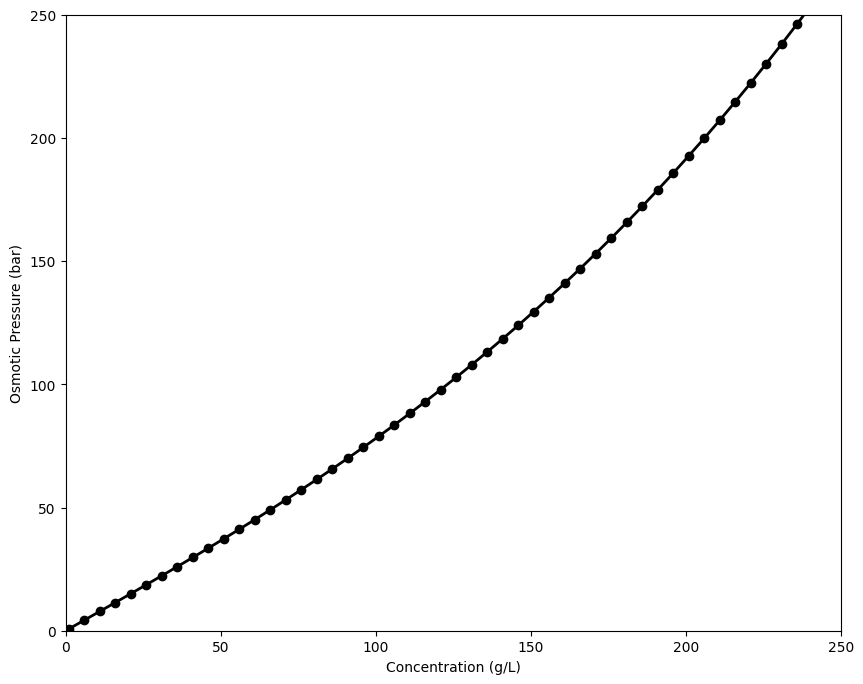

In [15]:
import matplotlib.pyplot as plt
# create figure
plt.figure(figsize=(10, 8))

# plot data
plt.plot(concentration_list, pressure_osm_list, "ko-", lw=2.0)

# format figure
plt.rc("font", size=18)
plt.xlabel("Concentration (g/L)")
plt.ylabel("Osmotic Pressure (bar)")
plt.xlim(0, 250)
plt.ylim(0, 250)

### Recap property model demonstration
* Property models create state blocks that relate state variables to the properties
* Properties are built on demand to reduce the model size
* Equation oriented modeling enables calculations in any direction
* Pyomo, IDAES, and WaterTAP support tracking and converting units of measurements

## Reverse Osmosis Demonstration
This section shows how to build, scale, initialize, and simulate the [reverse osmosis](https://watertap.readthedocs.io/en/latest/technical_reference/unit_models/reverse_osmosis_0D.html) (RO) unit model using WaterTAP.

### Import and build RO model

In [16]:
from watertap.unit_models.reverse_osmosis_0D import (ReverseOsmosis0D, ConcentrationPolarizationType, 
                                                     MassTransferCoefficient, PressureChangeType)

# create a Pyomo model
m = ConcreteModel()

# create IDAES flowsheet
m.fs = FlowsheetBlock(dynamic=False)

# create property model
m.fs.properties = properties.SeawaterParameterBlock()

# create RO unit model and specify options
m.fs.RO = ReverseOsmosis0D(
        property_package=m.fs.properties,
        has_pressure_change=True,
        pressure_change_type=PressureChangeType.calculated,
        mass_transfer_coefficient=MassTransferCoefficient.calculated,
        concentration_polarization_type=ConcentrationPolarizationType.calculated)

### Check degrees of freedom
There should be zero degrees of freedom for a simulation

In [17]:
from idaes.core.util.model_statistics import degrees_of_freedom
print("DOF =", degrees_of_freedom(m))

DOF = 11


### Specify values for RO variables

In [18]:
# fix the 4 inlet state variables
m.fs.RO.inlet.flow_mass_phase_comp[0, 'Liq', 'TDS'].fix(0.035)   # feed mass flowrate of TDS (kg/s)
m.fs.RO.inlet.flow_mass_phase_comp[0, 'Liq', 'H2O'].fix(0.965)   # feed mass flowrate of water (kg/s)
m.fs.RO.inlet.pressure[0].fix(50 * units.bar)                    # feed pressure (Pa)
m.fs.RO.inlet.temperature[0].fix(298)                            # feed temperature (K)

# fix 2 membrane properties
m.fs.RO.A_comp.fix(4.2e-12)                                      # membrane water permeability coeff (m/Pa/s)
m.fs.RO.B_comp.fix(3.5e-8)                                       # membrane salt permeability coeff (m/s)

# fix 5 module specficiations
m.fs.RO.area.fix(50)                                             # membrane stage area (m^2)
m.fs.RO.width.fix(5)                                             # membrane stage width (m)
m.fs.RO.feed_side.channel_height.fix(1 * units.mm)               # channel height in membrane stage (m)
m.fs.RO.feed_side.spacer_porosity.fix(0.97)                      # spacer porosity in membrane stage (-)
m.fs.RO.permeate.pressure[0].fix(101325)                         # permeate pressure (Pa)

print("DOF =", degrees_of_freedom(m))

DOF = 0


### Scale, initialize, and solve model

In [19]:
# scale the model
m.fs.properties.set_default_scaling('flow_mass_phase_comp', 1, index=('Liq', 'H2O'))
m.fs.properties.set_default_scaling('flow_mass_phase_comp', 1e2, index=('Liq', 'TDS'))
calculate_scaling_factors(m)

# initailize the model
m.fs.RO.initialize()

# solve the model
results = solver.solve(m)
print(results)

2025-09-10 12:56:40 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.RO.area
2025-09-10 12:56:40 [INFO] idaes.init.fs.RO.feed_side.properties_out: fs.RO.feed_side.properties_out State Released.
2025-09-10 12:56:40 [INFO] idaes.init.fs.RO.feed_side.properties_interface: fs.RO.feed_side.properties_interface State Released.
2025-09-10 12:56:40 [INFO] idaes.init.fs.RO.feed_side: Initialization Complete
2025-09-10 12:56:40 [INFO] idaes.init.fs.RO.permeate_side: fs.RO.permeate_side State Released.
2025-09-10 12:56:40 [INFO] idaes.init.fs.RO.mixed_permeate: fs.RO.mixed_permeate State Released.
2025-09-10 12:56:41 [INFO] idaes.init.fs.RO.feed_side.properties_in: fs.RO.feed_side.properties_in State Released.
2025-09-10 12:56:41 [INFO] idaes.init.fs.RO: Initialization Complete: optimal - Optimal Solution Found

Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 124
  Number of variables: 124
  Sense: unknown
Solver: 
- Status: ok
 

### Display report

In [20]:
m.fs.RO.report()


Unit : fs.RO                                                               Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                        : Value   : Units         : Fixed : Bounds
                 Membrane Area :  50.000 :    meter ** 2 :  True : (0.1, 100000.0)
    Solvent Mass Recovery Rate : 0.27361 : dimensionless : False : (0.01, 0.999999)
      Volumetric Recovery Rate : 0.27112 : dimensionless : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                              Units         Feed Inlet  Feed Outlet  Permeate Outlet
    flow_mass_phase_comp ('Liq', 'H2O')  kilogram / second     0.96500     0.70097        0.26403   
    flow_mass_phase_comp ('Liq', 'TDS')  kilogram / second    0.035000    0.034914     8.6051e-05   
    temperature                                     kelvin     

### Solve RO with fixed recovery
Fix volumetric water recovery and determine the area

In [21]:
# fix recovery and unfix area
m.fs.RO.recovery_vol_phase[0, "Liq"].fix(0.5)
m.fs.RO.area.unfix()

# solve model
solver = get_solver()
results = solver.solve(m)

# display report
m.fs.RO.report()


Unit : fs.RO                                                               Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                        : Value   : Units         : Fixed : Bounds
                 Membrane Area :  132.56 :    meter ** 2 : False : (0.1, 100000.0)
    Solvent Mass Recovery Rate : 0.50457 : dimensionless : False : (0.01, 0.999999)
      Volumetric Recovery Rate : 0.50000 : dimensionless :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                              Units         Feed Inlet  Feed Outlet  Permeate Outlet
    flow_mass_phase_comp ('Liq', 'H2O')  kilogram / second     0.96500     0.47809        0.48691   
    flow_mass_phase_comp ('Liq', 'TDS')  kilogram / second    0.035000    0.034755     0.00024479   
    temperature                                     kelvin     

## Full flowsheet optimization example
This section shows how to build, scale, initialize, and simulate a full flowsheet with cost optimization using WaterTAP.
<img src="assets_parameter_sweep_demo/RO_ERD_flowsheet.png" width="500" height="340">

### Import and build models

In [22]:
from pyomo.environ import TransformationFactory
from pyomo.network import Arc
from idaes.core.util.initialization import propagate_state
from idaes.models.unit_models import Product, Feed
from idaes.core import UnitModelCostingBlock
from watertap.unit_models.pressure_changer import Pump, EnergyRecoveryDevice
from watertap.costing import WaterTAPCosting

# setup model
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
m.fs.properties = properties.SeawaterParameterBlock()

# create unit models
m.fs.feed = Feed(property_package=m.fs.properties)
m.fs.pump = Pump(property_package=m.fs.properties)
m.fs.RO = ReverseOsmosis0D(
        property_package=m.fs.properties,
        has_pressure_change=True,
        pressure_change_type=PressureChangeType.calculated,
        mass_transfer_coefficient=MassTransferCoefficient.calculated,
        concentration_polarization_type=ConcentrationPolarizationType.calculated)
m.fs.erd = EnergyRecoveryDevice(property_package=m.fs.properties)
m.fs.product = Product(property_package=m.fs.properties)
m.fs.disposal = Product(property_package=m.fs.properties)

### Connect unit models

In [23]:
# connect unit models
m.fs.s1 = Arc(source=m.fs.feed.outlet, destination=m.fs.pump.inlet)
m.fs.s2 = Arc(source=m.fs.pump.outlet, destination=m.fs.RO.inlet)
m.fs.s3 = Arc(source=m.fs.RO.permeate, destination=m.fs.product.inlet)
m.fs.s4 = Arc(source=m.fs.RO.retentate, destination=m.fs.erd.inlet)
m.fs.s5 = Arc(source=m.fs.erd.outlet, destination=m.fs.disposal.inlet)
TransformationFactory("network.expand_arcs").apply_to(m)

### Add [costing](https://watertap.readthedocs.io/en/latest/technical_reference/costing/costing_base.html)

In [24]:
# costing model
m.fs.costing = WaterTAPCosting() 
# unit equipment capital and operating costs
m.fs.pump.work_mechanical[0].setlb(0)
m.fs.pump.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
m.fs.RO.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
m.fs.erd.costing = UnitModelCostingBlock(
        flowsheet_costing_block=m.fs.costing,
        costing_method_arguments={"energy_recovery_device_type": "pressure_exchanger"})

# system costing - total investment and operating costs
m.fs.costing.cost_process()
m.fs.costing.add_annual_water_production(m.fs.product.properties[0].flow_vol)
m.fs.costing.add_specific_energy_consumption(m.fs.product.properties[0].flow_vol)
m.fs.costing.add_LCOW(m.fs.product.properties[0].flow_vol)

2025-09-10 12:56:42 [WARNING] idaes.core.base.costing_base: flow_expr is an expression with a lower bound of less than zero. Costing requires that all flows have a lower bound equal to or greater than zero to avoid negative costs.


### Scale model

In [25]:
# scaling
# set default property values
m.fs.properties.set_default_scaling("flow_mass_phase_comp", 1, index=("Liq", "H2O"))
m.fs.properties.set_default_scaling("flow_mass_phase_comp", 1e2, index=("Liq", "TDS"))

# calculate and propagate scaling factors
calculate_scaling_factors(m)

2025-09-10 12:56:42 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.pump.control_volume.work
2025-09-10 12:56:42 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.RO.area
2025-09-10 12:56:42 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.erd.control_volume.work


### Check degrees of freedom

In [26]:
print("DOF = ", degrees_of_freedom(m))

DOF =  15


### Specify the flowsheet

In [27]:
# feed, 4 degrees of freedom
m.fs.feed.properties[0].flow_vol_phase["Liq"].fix(1e-3)                # volumetric flow rate (m3/s)
m.fs.feed.properties[0].mass_frac_phase_comp["Liq", "TDS"].fix(0.035)  # TDS mass fraction (-)
m.fs.feed.properties[0].pressure.fix(101325)                           # pressure (Pa)
m.fs.feed.properties[0].temperature.fix(273.15 + 25)                   # temperature (K)

# high pressure pump, 2 degrees of freedom
m.fs.pump.efficiency_pump.fix(0.80)                                    # pump efficiency (-)
m.fs.pump.control_volume.properties_out[0].pressure.fix(75e5)          # pump outlet pressure (Pa)

# RO unit, 7 degrees of freedom
m.fs.RO.A_comp.fix(4.2e-12)                                            # membrane water permeability coeff (m/Pa/s)
m.fs.RO.B_comp.fix(3.5e-8)                                             # membrane salt permeability coeff (m/s)
m.fs.RO.recovery_vol_phase[0, "Liq"].fix(0.5)                          # volumetric recovery (-) *
m.fs.RO.feed_side.velocity[0, 0].fix(0.15)                             # crossflow velocity (m/s) *
m.fs.RO.feed_side.channel_height.fix(1e-3)                             # channel height in membrane stage (m)
m.fs.RO.feed_side.spacer_porosity.fix(0.97)                            # spacer porosity in membrane stage (-)
m.fs.RO.permeate.pressure[0].fix(101325)                               # permeate pressure (Pa)

# energy recovery device, 2 degrees of freedom
m.fs.erd.efficiency_pump.fix(0.80)                                     # erd efficiency (-)
m.fs.erd.control_volume.properties_out[0].pressure.fix(101325)         # ERD outlet pressure (Pa)

print("DOF = ", degrees_of_freedom(m))

DOF =  0


### Initialize and solve the flowsheet

In [28]:
# initialize unit by unit
solver = get_solver()

# solve feed
solver.solve(m.fs.feed)

# initialize pump
propagate_state(m.fs.s1)
m.fs.pump.initialize()

# initialize RO
propagate_state(m.fs.s2)
m.fs.RO.initialize()

# initialize energy recovery device
propagate_state(m.fs.s4)
m.fs.erd.initialize()

# propagate to product and disposal
propagate_state(m.fs.s3)
propagate_state(m.fs.s5)

# initialize cost
m.fs.costing.initialize()

# solve model
results = solver.solve(m) 
print(results)

2025-09-10 12:56:42 [INFO] idaes.init.fs.pump.control_volume.properties_out: fs.pump.control_volume.properties_out State Released.
2025-09-10 12:56:42 [INFO] idaes.init.fs.pump.control_volume: Initialization Complete
2025-09-10 12:56:42 [INFO] idaes.init.fs.pump.control_volume.properties_in: fs.pump.control_volume.properties_in State Released.
2025-09-10 12:56:42 [INFO] idaes.init.fs.pump: Initialization Complete: optimal - Optimal Solution Found
2025-09-10 12:56:42 [INFO] idaes.init.fs.RO.feed_side.properties_out: fs.RO.feed_side.properties_out State Released.
2025-09-10 12:56:42 [INFO] idaes.init.fs.RO.feed_side.properties_interface: fs.RO.feed_side.properties_interface State Released.
2025-09-10 12:56:42 [INFO] idaes.init.fs.RO.feed_side: Initialization Complete
2025-09-10 12:56:42 [INFO] idaes.init.fs.RO.permeate_side: fs.RO.permeate_side State Released.
2025-09-10 12:56:42 [INFO] idaes.init.fs.RO.mixed_permeate: fs.RO.mixed_permeate State Released.
2025-09-10 12:56:43 [INFO] idaes

### Display results

In [29]:
def display_solution(m):
    print("----------system metrics----------")
    print("Recovery: %.1f %%" % (value(m.fs.RO.recovery_vol_phase[0, "Liq"])*100))
    print("Specific energy: %.2f kWh/m3" % value(m.fs.costing.specific_energy_consumption))
    print("Levelized cost of water: %.2f $/m3" % value(m.fs.costing.LCOW))

    print("\n----------inlet and outlets----------")
    print("Feed: %.2f m3/h, %.0f ppm" %
          (value(units.convert(m.fs.feed.properties[0].flow_vol_phase["Liq"],
                               to_units=units.m ** 3 / units.hr)),
           value(m.fs.feed.properties[0].mass_frac_phase_comp["Liq", "TDS"]) * 1e6))
    print("Product: %.2f m3/h, %.0f ppm" %
          (value(units.convert(m.fs.product.properties[0].flow_vol_phase["Liq"],
                               to_units=units.m ** 3 / units.hr)),
           value(m.fs.product.properties[0].mass_frac_phase_comp["Liq", "TDS"]) * 1e6))
    print("Disposal: %.2f m3/h, %.0f ppm" %
          (value(units.convert(m.fs.disposal.properties[0].flow_vol_phase["Liq"],
                               to_units=units.m ** 3 / units.hr)),
           value(m.fs.disposal.properties[0].mass_frac_phase_comp["Liq", "TDS"]) * 1e6))

    print("\n----------decision variables----------")
    print("Operating pressure: %.1f bar" %
          (value(units.convert(m.fs.pump.control_volume.properties_out[0].pressure,
                               to_units=units.bar))))
    print("Membrane area: %.1f m2" % value(m.fs.RO.area))
    print("Inlet crossflow velocity: %.1f cm/s" %
          (value(units.convert(m.fs.RO.feed_side.velocity[0, 0],
                               to_units=units.cm / units.s))))

    print("\n----------system variables----------")
    print("Pump power: %.1f kW" %
          (value(units.convert(m.fs.pump.work_mechanical[0], to_units=units.kW))))
    print("ERD power: %.1f kW" %
          (-value(units.convert(m.fs.erd.work_mechanical[0], to_units=units.kW))))
    print("Average water flux: %.1f L/(m2-h)" %
          value(units.convert(m.fs.RO.flux_mass_phase_comp_avg[0, "Liq", "H2O"]
                              / (1000 * units.kg / units.m ** 3),
                              to_units=units.mm / units.hr)))
    print("Pressure drop: %.1f bar" %
          (-value(units.convert(m.fs.RO.deltaP[0],to_units=units.bar))))
    print("Maximum interfacial salinity: %.0f ppm" %
          (value(m.fs.RO.feed_side.properties_interface[0, 1].mass_frac_phase_comp["Liq", "TDS"])*1e6))

display_solution(m)

----------system metrics----------
Recovery: 50.0 %
Specific energy: 3.50 kWh/m3
Levelized cost of water: 0.64 $/m3

----------inlet and outlets----------
Feed: 3.60 m3/h, 35000 ppm
Product: 1.80 m3/h, 275 ppm
Disposal: 3600.00 m3/h, 100000 ppm

----------decision variables----------
Operating pressure: 75.0 bar
Membrane area: 56.1 m2
Inlet crossflow velocity: 15.0 cm/s

----------system variables----------
Pump power: 9.2 kW
ERD power: 2.9 kW
Average water flux: 32.0 L/(m2-h)
Pressure drop: 0.4 bar
Maximum interfacial salinity: 79886 ppm


## Setup cost optimization

In [30]:
# objective
m.fs.objective = Objective(expr=m.fs.costing.LCOW)  # minimize the LCOW

# unfix decision variables and add bounds
# pump pressure
m.fs.pump.control_volume.properties_out[0].pressure.unfix()
m.fs.pump.control_volume.properties_out[0].pressure.setlb(10e5)
m.fs.pump.control_volume.properties_out[0].pressure.setub(85e5)
m.fs.pump.deltaP.setlb(0)

# RO crossflow velocity
m.fs.RO.feed_side.velocity[0, 0].unfix()
m.fs.RO.feed_side.velocity.setlb(0.01)
m.fs.RO.feed_side.velocity.setub(1)
m.fs.RO.area.setlb(1)
m.fs.RO.area.setub(200)

# check degrees of freedom
# operating pressure + membrane area + crossflow velocity (i.e. width) - specified water recovery
print("DOF = ", degrees_of_freedom(m))

DOF =  2


## Solve the optimization problem and display results

In [31]:
results = solver.solve(m)
print(results)


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 206
  Number of variables: 208
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.043860673904418945
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [32]:
display_solution(m)

----------system metrics----------
Recovery: 50.0 %
Specific energy: 2.24 kWh/m3
Levelized cost of water: 0.53 $/m3

----------inlet and outlets----------
Feed: 3.60 m3/h, 35000 ppm
Product: 1.80 m3/h, 535 ppm
Disposal: 1.80 m3/h, 67741 ppm

----------decision variables----------
Operating pressure: 47.0 bar
Membrane area: 154.8 m2
Inlet crossflow velocity: 23.0 cm/s

----------system variables----------
Pump power: 5.7 kW
ERD power: 1.7 kW
Average water flux: 11.6 L/(m2-h)
Pressure drop: 3.3 bar
Maximum interfacial salinity: 67973 ppm


### Change the membrane capital cost and reoptimize

In [33]:
# double the membrane costs
m.fs.costing.reverse_osmosis.membrane_cost.fix(60)

# resolve
results = solver.solve(m)
display_solution(m)

----------system metrics----------
Recovery: 50.0 %
Specific energy: 2.78 kWh/m3
Levelized cost of water: 0.64 $/m3

----------inlet and outlets----------
Feed: 3.60 m3/h, 35000 ppm
Product: 1.80 m3/h, 379 ppm
Disposal: 1.80 m3/h, 67882 ppm

----------decision variables----------
Operating pressure: 59.1 bar
Membrane area: 90.9 m2
Inlet crossflow velocity: 22.9 cm/s

----------system variables----------
Pump power: 7.3 kW
ERD power: 2.3 kW
Average water flux: 19.7 L/(m2-h)
Pressure drop: 1.9 bar
Maximum interfacial salinity: 70277 ppm


### Summary points on cost-optimization of flowsheet models in WaterTAP
* Water treatment trains can be rapidly assembled
* WaterTAP can optimize multiple decision variables in seconds
* All parameters and variables can be modified for sensitivity analyses